#Task A

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Read the given data and prepare the data similar to the format mentioned in the product network paper by computing the sentiment scores between two products.

In [3]:
network = pandas.read_csv('Sentiment_scores.csv')
columns=network.columns.values

for p in xrange(len(columns)-1):
    for q in xrange(p+1,len(columns)):
        name= columns[p]+'-'+columns[q]
        network[name]=network[columns[p]]-network[columns[q]]

network_columns=network.columns.values[10:]
network1=network[network_columns]
product_network={}
for name in network_columns:
    temp=network1[network1[name].notnull()][name]
    temp1=temp[temp >0]
    temp2=temp[temp <0]
    if len(temp1) == 0:
        temp1=0
    if len(temp2) == 0:
        temp2=0
    product_network[name]=[mean(temp1),abs(mean(temp2))]

####Determine the corresponding edges for the different product - product combinations. The edges are obtained from the positive and the negative sentiments based for different products and a list for weighted and unweighted edges are added.

In [4]:
import re
import networkx as nx
import matplotlib.pyplot as plt
list_without_weights=[]
for i in product_network.keys():
    list_without_weights.append(re.split('-', i)) # split on - to get individual product names

nodes=set([n1 for n1, n2 in list_without_weights] + [n2 for n1, n2 in list_without_weights]) # getting all the nodes

list_with_weights=[]
for edge in list_without_weights:
    name=edge[0]+'-'+edge[1] # to access the product network weights
    if(product_network[name][0] <> 0): # no edges for zero values
        list_with_weights.append((edge[1], edge[0],product_network[name][0]))# postive sentiment ( product A to B)
    if (abs(product_network[name][1] <> 0)): # negative sentiment( product B to A)
        list_with_weights.append((edge[0], edge[1],product_network[name][1]))



####A weighted multidigraph is plotted using the sentiment scores calculated. The sentiment scores not only provide the direction of preference (positive or negative) between two products but also provide the weights for the preference of the products.

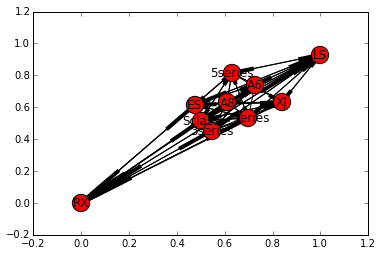

In [5]:
#MultiDigraph with weights
MultiDiGraph = nx.MultiDiGraph() 
MultiDiGraph.add_nodes_from (nodes,name=nodes)

MultiDiGraph.add_weighted_edges_from(list_with_weights)
    
nx.draw_networkx(MultiDiGraph)

#### Similarly a unweighted multidigraph is plotted by only using the direction of edges between the two product nodes across the network

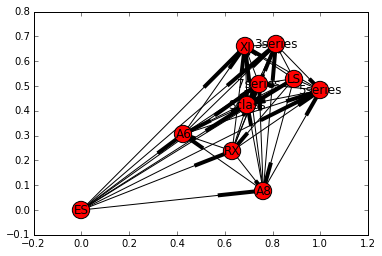

In [6]:
#MultiDigraph without  weights
MultiDiGraph_wo = nx.MultiDiGraph() 
MultiDiGraph_wo.add_nodes_from (nodes,name=nodes)

MultiDiGraph_wo.add_edges_from(list_without_weights)

nx.draw_networkx(MultiDiGraph_wo)

#Task B

###Comparing the correlation between the product network model and the actual sales of the models. The weighted and the unweighted models built in the above task are used to compare the correlation with the sales data

In [7]:
import scipy
from scipy import stats
import pandas as pd
Sales_dict = {'3series': 220000,
 '5series': 60000,
 '7series': 14000,
 'A6': 20000,
 'A8': 12000,
 'ES': 135000,
 'LS': 30000,
 'RX': 120000,
 'Sclass': 25000,
 'XJ': 6600}
df = pd.DataFrame({'Sales': Sales_dict, 'Unweighted PageRank': nx.pagerank_numpy(MultiDiGraph_wo), 
                      'Weighted PageRank': nx.pagerank_numpy(MultiDiGraph) })


####The correlation is measured by using the following: Kendall, Spearman & Pearson techniques

In [8]:
saleslist = df['Sales'].tolist()
UPRlist = df['Unweighted PageRank'].tolist()
WPRlist = df['Weighted PageRank'].tolist()
tau_uw, p_value_uw = stats.kendalltau(saleslist, UPRlist)
rho_uw, pval_uw = stats.spearmanr(saleslist, UPRlist)
corr_uw, p_val_uw = stats.pearsonr(saleslist, UPRlist)
stats_dict = {'Kendall Corr': tau_uw,
               'Kendall P-Value': p_value_uw,
               'Spearman Corr': rho_uw,
                'Spearman P-Value': pval_uw,
                 'Pearson(Standard) Corr': corr_uw,
                 'Pearson (Standard) P-Value': p_val_uw}
tau_w, p_value_w = stats.kendalltau(saleslist, WPRlist)
rho_w, pval_w = stats.spearmanr(saleslist, WPRlist)
corr_w, p_val_w = stats.pearsonr(saleslist, WPRlist)
stats_dict_w = {'Kendall Corr': tau_w,
               'Kendall P-Value': p_value_w,
               'Spearman Corr': rho_w,
                'Spearman P-Value': pval_w,
                'Pearson(Standard) Corr': corr_w,
                 'Pearson (Standard) P-Value': p_val_w}
df_stats = pd.DataFrame({'Unweighted PageRank': stats_dict, 'Weighted PageRank': stats_dict_w})
df_stats

,Unweighted PageRank,Weighted PageRank
Kendall Corr,-0.333333,0.600000
Kendall P-Value,0.179713,0.015737
Pearson (Standard) P-Value,0.337547,0.015141
Pearson(Standard) Corr,-0.339262,0.736432
Spearman Corr,-0.454545,0.721212
Spearman P-Value,0.186905,0.018573


####The results of the model show that the correlation is stronger when we consider a weighted PageRank over an unweighted PageRank network model.

#Task C

###We create a sentiment matrix for the different car models by analyzing the text reviews posted by the users (available in the data provided), build a PageRank network using a similar algorithm as above and compare the correlation of the PageRanks to the sales of the models. The required libraries are first loaded along with the data.

In [9]:
%matplotlib inline  
import nltk
import pandas as pd
from collections import Counter
import string
from nltk.corpus import stopwords
from string import punctuation
import math
import re
import sys
sys.path.append('C:\Python27\Lib\site-packages')
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer

####We first read the posts from the csv file and preprocess the data. To compute the sentiments, we identity whether if the model is mentioned in the review and if yes, we retrieve the sentiments of the 5 closest words on either side of the model name. We assume this to correspond to the sentiment of the product. 

In [12]:
posts = pd.read_csv('Assignment 3 Edmunds Posts.csv', sep = '\n')
posts['Posts'] = posts['Posts'].str.lower()
posts['Posts'] = posts['Posts'].apply(nltk.word_tokenize)
stopset = set(stopwords.words('english'))

wnl = WordNetLemmatizer()

for i, row in enumerate(posts.values):
    for w in row:
        row_item = ''
        for w1 in w:
            if (not w1 in stopset and not w1 in list(punctuation)):
                row_item = row_item + ' '+ w1
        posts['Posts'].loc[i] = row_item
        
posts['es'] = ''
posts['ls'] = ''
posts['rx'] = ''
posts['a8'] = ''
posts['a6'] = ''
posts['3series'] = ''
posts['5series'] = ''
posts['7series'] = ''
posts['xj'] = ''
posts['sclass'] = ''

model_list = ['es', 'ls', 'rx', 'a8', 'a6', '3series', '5series', '7series', 'xj', 'sclass']
left = []
right = []
for i, row in enumerate(posts.values):
    for sentence in row:
        try:
            words = re.findall(r'\w+', sentence)
        except:
            pass
        for model in model_list:
            try:
                index = words.index(model)
                if(index - 5 < 0):
                    left = words[0:index]
                else:
                    left = words[index - 5:index]
                if(index + 6 > len(words)):
                    right = words[index + 1:len(words)]
                else:
                    right = words[index + 1: index + 6]
            except:
                pass
            if left and right:
                all_words = left + right
                line = ' '.join(all_words)
                score = math.floor(TextBlob(line).sentiment.polarity * 5)
                posts[model].loc[i] = score
            else:
                posts[model].loc[i] = None
            left = []
            right = []
            line = ''
            score = 0

network = posts[['es','ls','rx','a8','a6', '3series', '5series', '7series', 'xj', 'sclass']]
columns = network.columns.values

####Sample from the new dataframe created. This dataframe is used to compute the sentiments between the products in a review and passed through the weighted and the unweighted model algorithms to compute the PageRank neworks

In [11]:
print network[:10]

     es    ls    rx    a8    a6 3series 5series 7series    xj sclass
0  None     1  None     1  None    None    None    None  None      0
1  None  None  None     1  None    None    None       0  None      0
2  None  None     2  None  None    None    None    None  None   None
3  None  None     0  None  None       0    None       0  None      1
4  None  None  None  None  None    None    None    None  None      1
5  None  None     0  None  None    None    None    None  None     -1
6  None  None  None     0  None    None    None    None  None   None
7  None  None  None     0  None    None    None    None  None   None
8  None     0  None  None  None    None    None       0  None      0
9  None  None  None     2  None    None    None    None     2   None


In [13]:
for p in xrange(len(columns)-1):
    for q in xrange(p+1,len(columns)):
        name= columns[p]+'-'+columns[q]
        network[name]=network[columns[p]]-network[columns[q]]

network_columns=network.columns.values[10:]
network1=network[network_columns]
product_network={}
for name in network_columns:
    temp=network1[network1[name].notnull()][name]
    temp1=temp[temp >0]
    temp2=temp[temp <0]
    if len(temp1) == 0:
        temp1=0
    if len(temp2) == 0:
        temp2=0
    product_network[name]=[mean(temp1),abs(mean(temp2))]

In [14]:
import re
import networkx as nx
import matplotlib.pyplot as plt
list_without_weights=[]
for i in product_network.keys():
    list_without_weights.append(re.split('-', i)) # split on - to get individual product names

nodes=set([n1 for n1, n2 in list_without_weights] + [n2 for n1, n2 in list_without_weights]) # getting all the nodes

list_with_weights=[]
for edge in list_without_weights:
    name=edge[0]+'-'+edge[1] # to access the product network weights
    if(product_network[name][0] <> 0): # no edges for zero values
        list_with_weights.append((edge[1], edge[0],product_network[name][0]))# postive sentiment ( product A to B)
    if (abs(product_network[name][1] <> 0)): # negative sentiment( product B to A)
        list_with_weights.append((edge[0], edge[1],product_network[name][1]))



#### Create a multidigraph with weights

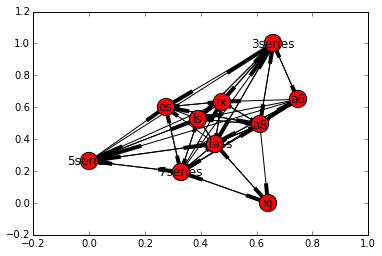

In [15]:
#MultiDigraph with weights
MultiDiGraph = nx.MultiDiGraph() 
MultiDiGraph.add_nodes_from (nodes,name=nodes)

MultiDiGraph.add_weighted_edges_from(list_with_weights)
    
nx.draw_networkx(MultiDiGraph)


####Create a multi di graph without weights

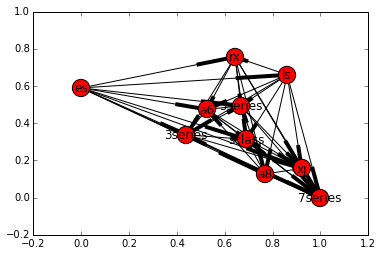

In [16]:
#MultiDigraph without  weights
MultiDiGraph_wo = nx.MultiDiGraph() 
MultiDiGraph_wo.add_nodes_from (nodes,name=nodes)

MultiDiGraph_wo.add_edges_from(list_without_weights)

nx.draw_networkx(MultiDiGraph_wo)

In [17]:
import pandas as pd
Sales_dict = {'3series': 220000,
 '5series': 60000,
 '7series': 14000,
 'a6': 20000,
 'a8': 12000,
 'es': 135000,
 'ls': 30000,
 'rx': 120000,
 'sclass': 25000,
 'xj': 6600}
df = pd.DataFrame({'Sales': Sales_dict, 'Unweighted PageRank': nx.pagerank_numpy(MultiDiGraph_wo), 
                      'Weighted PageRank': nx.pagerank_numpy(MultiDiGraph) })
df

,Sales,Unweighted PageRank,Weighted PageRank
3series,220000,0.073998,0.123135
5series,60000,0.089723,0.068792
7series,14000,0.115145,0.082341
a6,20000,0.063247,0.065035
a8,12000,0.055398,0.105578
es,135000,0.040802,0.147563
ls,30000,0.044655,0.106103
rx,120000,0.049400,0.169451
sclass,25000,0.303550,0.100437
xj,6600,0.164081,0.031565


In [18]:
saleslist = df['Sales'].tolist()
UPRlist = df['Unweighted PageRank'].tolist()
WPRlist = df['Weighted PageRank'].tolist()
tau_uw, p_value_uw = stats.kendalltau(saleslist, UPRlist)
rho_uw, pval_uw = stats.spearmanr(saleslist, UPRlist)
corr_uw, p_val_uw = stats.pearsonr(saleslist, UPRlist)
stats_dict = {'Kendall Corr': tau_uw,
               'Kendall P-Value': p_value_uw,
               'Spearman Corr': rho_uw,
                'Spearman P-Value': pval_uw,
                 'Pearson(Standard) Corr': corr_uw,
                 'Pearson (Standard) P-Value': p_val_uw}
tau_w, p_value_w = stats.kendalltau(saleslist, WPRlist)
rho_w, pval_w = stats.spearmanr(saleslist, WPRlist)
corr_w, p_val_w = stats.pearsonr(saleslist, WPRlist)
stats_dict_w = {'Kendall Corr': tau_w,
               'Kendall P-Value': p_value_w,
               'Spearman Corr': rho_w,
                'Spearman P-Value': pval_w,
                'Pearson(Standard) Corr': corr_w,
                 'Pearson (Standard) P-Value': p_val_w}
df_stats = pd.DataFrame({'Unweighted PageRank': stats_dict, 'Weighted PageRank': stats_dict_w})
df_stats

,Unweighted PageRank,Weighted PageRank
Kendall Corr,-0.333333,0.511111
Kendall P-Value,0.179713,0.039669
Pearson (Standard) P-Value,0.337547,0.043611
Pearson(Standard) Corr,-0.339262,0.645989
Spearman Corr,-0.454545,0.721212
Spearman P-Value,0.186905,0.018573


####The final correlations are obtained as above for the new model that has been created. The weighted pagerank again performs better than the unweighted pagerank in retrieving the correlation between the PageRank (sentiments) and the sales